In [ ]:
a = []
while(1):
  a.append("1")

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)

In [ ]:
!pip install tensorflow==2.0.0-alpha0 

In [ ]:
import os 
import time
import cv2
import imutils
import numpy as np 
import matplotlib.pyplot as plt
import keras 
import random 

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.metrics import f1_score, confusion_matrix, classification_report 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import  Callback

Using TensorFlow backend.


In [ ]:
!rm -rf sample_data
!unzip  "/content/drive/My Drive/Data Classification.zip"

In [ ]:
def hms_string(sec):
    h = int(sec / (60 * 60))
    m = int((sec % (60 * 60)) / 60)
    s = sec % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def VGG16_model(target):
  vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tensorflow_dim_ordering_tensorflow_kernels_notop.h5'
  model_vgg = VGG16(weights=vgg16_weight_path, include_top=False, input_shape = target)
  last_layer = model_vgg.get_layer("block5_conv1")
  last_output = last_layer.output
  x = layers.Flatten()(last_output)
  x = layers.Dense(576, activation='relu')(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(32, activation='relu')(x)
  x = layers.Dense(8, activation='relu')(x)
  x = layers.Dense (1, activation='sigmoid')(x)           
  model = Model(model_vgg.input, x) 
  layer_names = [layer.name for layer in model.layers]
  return model

In [ ]:
def New_Architecture(target):
  model = Sequential()
  model.add(Conv2D(filters = 64, kernel_size = (7,7), strides = (1,1), data_format = "channels_last",
                   input_shape = target, activation = "relu"))
  model.add(Conv2D(filters = 64, kernel_size = (7,7), strides = (1,1),activation = "relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(filters = 128, kernel_size = (5,5), strides = (1,1),activation = "relu"))
  model.add(Conv2D(filters = 128, kernel_size = (5,5), strides = (1,1),activation = "relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(filters = 512, kernel_size = (3,3), strides = (1,1),activation = "relu"))
  model.add(Conv2D(filters = 512, kernel_size = (3,3), strides = (1,1),activation = "relu"))
  model.add(Flatten())
  model.add(Dense(578, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(32, activation="relu"))
  model.add(Dense(8, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  return model 

In [ ]:
def AlexNet(target):  
  model = Sequential()
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), padding = "valid",
                   data_format = "channels_last", input_shape = target, activation = "relu"))

  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding="valid", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid", activation="relu"))
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"))
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid", activation="relu"))

  model.add(Flatten())
  model.add(Dense(4096, activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(578, activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(8, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  return model


In [ ]:
dire = "cropped_Data/"
train = os.path.join(dire,"Train")
test = os.path.join(dire,"Test")
Validation = os.path.join(dire,"Validation")

In [ ]:
tar_size = (200,200)
train_dt = ImageDataGenerator(rotation_range=15,
                              rescale=1./255,
                              brightness_range=[0.1, 1.5],
                              horizontal_flip=True,
                              vertical_flip=True, 
                              fill_mode='nearest')

valid_dt = ImageDataGenerator(rescale = 1./255)
                              

train_gene = train_dt.flow_from_directory(train,
                                          target_size = tar_size,
                                          batch_size = 64,
                                          class_mode = "binary")

valid_gene = valid_dt.flow_from_directory(Validation,
                                          target_size = tar_size,
                                          class_mode = "binary")

Found 4879 images belonging to 2 classes.
Found 442 images belonging to 2 classes.


In [ ]:
model_1 = New_Architecture((tar_size[0],tar_size[1],3))
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 194, 194, 64)      9472      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 188, 188, 64)      200768    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 94, 94, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 86, 86, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 512)       5

In [ ]:
model_1.compile(optimizer = Adam(learning_rate=0.001),
                  loss = 'binary_crossentropy',        
                  metrics = ['acc'])
history = model_1.fit_generator(train_gene , epochs=15, shuffle=True,
                                validation_data=valid_gene)

Epoch 1/15
77/77 [==============================] - 57s 741ms/step - loss: 0.0282 - acc: 0.9912 - val_loss: 0.0280 - val_acc: 0.9910
Epoch 2/15
77/77 [==============================] - 57s 741ms/step - loss: 0.0117 - acc: 0.9957 - val_loss: 0.0116 - val_acc: 0.9977
Epoch 3/15
56/77 [====================>.........] - ETA: 15s - loss: 0.0336 - acc: 0.9924

KeyboardInterrupt: ignored

In [ ]:
print(type(history))

<class 'tensorflow.python.keras.callbacks.History'>


In [ ]:
def Visualize_acc(hist):
  acc = hist.history["acc"]
  val_acc = hist.history["val_acc"]
  loss = hist.history["loss"]
  val_loss = hist.history["val_loss"]

  epoch = range(len(acc))
  plt.plot(epoch, acc, label="accurcay train")
  plt.plot(epoch, val_acc, label="accurcay Valid")
  plt.show()
  plt.plot(epoch, loss,'o', label="Loss train")
  plt.plot(epoch, val_loss,'r', label="Loss Valid")
  plt.show()

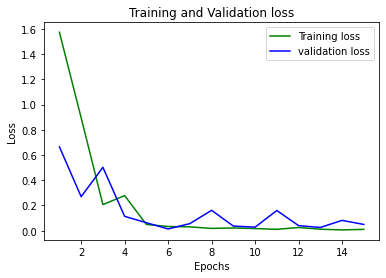

<Figure size 432x288 with 0 Axes>

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('Loss_MyArchitecture.jpg')

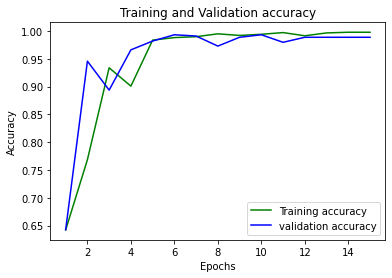

In [ ]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()